# Tarea INFO286: Minería de Procesos

Integrantes: Felipe Córdova y Javier Reyes  
Profesor: Juan Salazar  
Fecha: 09/05/2025  


## Resumen

En este trabajo se analiza el log de eventos `traffic_fines`, el cual representa el proceso de gestión de multas de tránsito en Italia. Se utilizaron herramientas del ecosistema `bupaR` en R para explorar el log, visualizar el proceso, responder preguntas específicas y proponer mejoras. Se identificaron cuellos de botella, variantes comunes y actividades críticas. Entre los principales hallazgos destacan demoras considerables en ciertas etapas y la existencia de múltiples variantes del proceso. Se proponen dos mejoras orientadas a reducir tiempos muertos y simplificar el flujo de actividades.


### Instalación y carga de paquetes

In [104]:
# Instalar los paquetes solo la primera vez:
# install.packages("bupaR")
# install.packages("eventdataR")  # contiene el log traffic_fines
# install.packages("edeaR")       # análisis exploratorio
# install.packages("processmapR") # mapas de proceso
# install.packages("processmonitR") # monitoreo

# Cargar los paquetes:
library(bupaR)
library(eventdataR)
library(edeaR)
library(processmapR)
library(processmonitR)
library(ggplot2)

### Cargar el log *traffic_fines*

In [105]:
data("traffic_fines")

## 1. Descripción general del log

En esta sección se realiza una revisión exploratoria de los datos del proceso, identificando aspectos clave como la cantidad de casos, el número de actividades distintas, las ventanas de tiempo involucradas, la duración de los casos, la cantidad y distribución de variantes, así como los participantes que intervienen en el proceso.

Dado que el log ya ha sido cargado, procedemos a presentar un resumen general de los datos.

In [106]:
# Resumen general del log
summary(traffic_fines)

Number of events:  34724
Number of cases:  10000
Number of traces:  44
Number of distinct activities:  11
Average trace length:  3.4724

Start eventlog:  2006-06-17
End eventlog:  2012-03-26



   case_id                                activity        lifecycle    
 Length:34724       Create Fine               :10000   complete:34724  
 Class :character   Send Fine                 : 6570                   
 Mode  :character   Payment                   : 4910                   
                    Add penalty               : 4635                   
                    Insert Fine Notification  : 4635                   
                    Send for Credit Collection: 3387                   
                    (Other)                   :  587                   
    resource       timestamp                         amount         
 559    : 1278   Min.   :2006-06-17 00:00:00.00   Length:34724      
 557    : 1181   1st Qu.:2007-07-19 00:00:00.00   Class :character  
 541    : 1119   Median :2007-10-29 00:00:00.00   Mode  :character  
 561    : 1002   Mean   :2007-12-06 15:34:51.32                     
 558    :  948   3rd Qu.:2008-02-29 00:00:00.00                     
 (Other): 

Algunos de los datos solicitados pueden observarse en el resumen general obtenido previamente mediante la función `summary(data)` en R. Sin embargo, a continuación se presentan algunos comandos específicos de la librería bupaR que permiten visualizar esta información de manera más clara y detallada.

In [107]:
# Número de casos
n_cases(traffic_fines)

[1] 10000

In [108]:
# Número de actividades distintas
n_activities(traffic_fines)

[1] 11

In [109]:
# Ver el nombre de las 11 actividades
activities(traffic_fines)

activity,absolute_frequency,relative_frequency
<fct>,<int>,<dbl>
Create Fine,10000,0.287985255
Send Fine,6570,0.189206313
Payment,4910,0.141400760
Add penalty,4635,0.133481166
Insert Fine Notification,4635,0.133481166
Send for Credit Collection,3387,0.097540606
Insert Date Appeal to Prefecture,232,0.006681258
Send Appeal to Prefecture,227,0.006537265
Receive Result Appeal from Prefecture,55,0.001583919


In [110]:
# Ventana de tiempo que abarca
start_time <- min(traffic_fines$timestamp)
end_time <- max(traffic_fines$timestamp)
start_time
end_time

[1] "2006-06-17 UTC"

[1] "2012-03-26 UTC"

In [111]:
# Duración de los casos (tiempo total de ejecución de los casos)
throughput_time(traffic_fines, units="days")

# Duración de los casos (tiempo de cada caso individual)
# throughput_time(traffic_fines, units = "days", level = "case")

min,q1,median,mean,q3,max,st_dev,iqr
<drtn>,<drtn>,<drtn>,<drtn>,<drtn>,<drtn>,<dbl>,<drtn>
0 days,7 days,125 days,296.1351 days,596 days,1956 days,313.2794,589 days


[1] 3

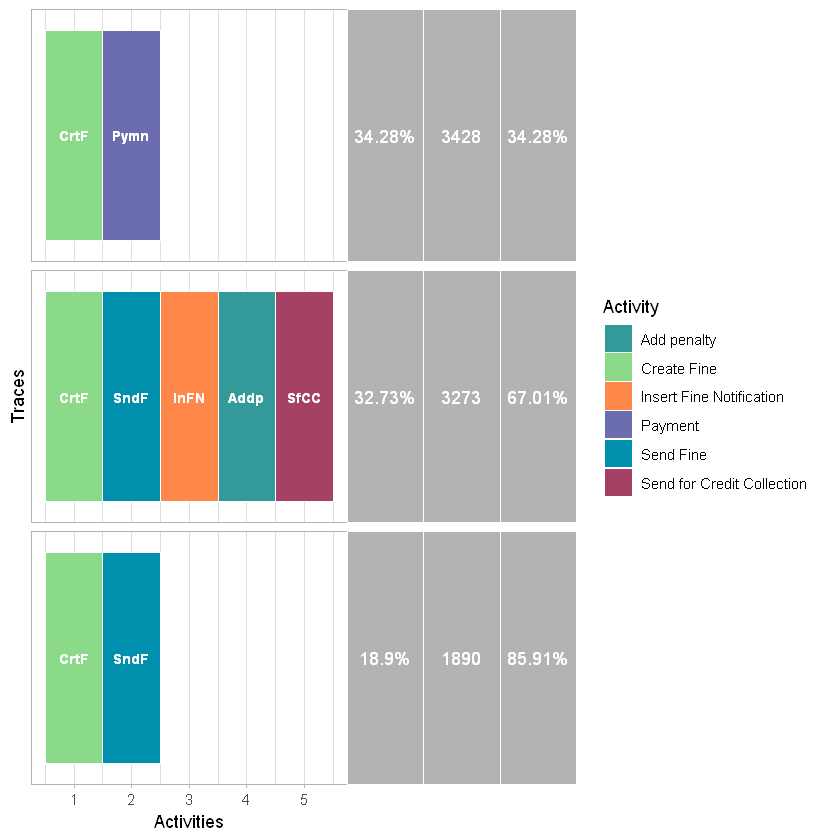

In [112]:
# Distribución de variantes --> Aqui claramente se ve que son 3, pero igual lo hicimos por comando
trace_explorer(traffic_fines, coverage = 0.8)

# Cantidad de variantes
length(unique(trace_list(traffic_fines)))


In [113]:
# Personas que participan en el proceso en %
resource_frequency(traffic_fines, level = "resource") %>%
  mutate(percentage = absolute / sum(absolute) * 100)


resource,absolute,relative,percentage
<fct>,<int>,<dbl>,<dbl>
NA,24705,0.7114675729,71.14675729
559,1278,0.0368045156,3.68045156
557,1181,0.0340110586,3.40110586
541,1119,0.0322255501,3.22255501
561,1002,0.0288561226,2.88561226
558,948,0.0273010022,2.73010022
537,946,0.0272434051,2.72434051
564,602,0.0173367124,1.73367124
556,600,0.0172791153,1.72791153


In [114]:
# Una lista de las personas que participan en el proceso (Las mismas mostradas anteriormente en la tabla)
traffic_fines %>% resource_labels()

[1] 561  <NA> 537  550  541  557  558  559  0    536  560  562  563  564  556 
[16] 538 
148 Levels: 0 3 4 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 ... 870

### Descripción General 

| Información | Cantidad | 
| :--| :-- |
| Número de casos |  10000 casos |
| Número de actividades únicas | 11 actividades |
| Ventana de tiempo | [2006-06-17, 2012-03-26] |
| Duración de los casos | En promedio 296.1351 días |
| Cantidad de variantes | 44 variantes (traces) |
| Distribución de variantes |  |
| Personas / Roles que participan | 561 / NA (persona no registrada) / 537 / 550 / 541 / 557 / 558 / 559 / 0 / 536 / 560 / 562 / 563 / 564 / 556 / 538 | 
| Con qué información se cuenta | Los procesos empiezan con **Create fine**, y terminan con: **Payment**, **Send for Credit Colletion** y **Send fine** |
| Con qué información no se cuenta | No tenemos datos del vehículo, podría ser relevante para analizar las infracciones según el tipo de vehículo. No tenemos detalles de la infracción, algunas pueden ser mas graves que otras y puede reflejarse en el valor de la multa.

## 2. Análisis del diagrama del proceso


## 3. Análisis del log mediante preguntas


## 4. Propuesta de mejoras al proceso


## Conclusión

Resumen de lo aprendido, limitaciones y posibles mejoras futuras del análisis.
